In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Cat vs. Dog Clasificación de Imágenes
## Ejercicio 2: Reducción del Sobreentrenamiento
**_Tiempo estimado: 30 minutos_**

En este ejercicio vamos a mejorar el modelo creado en el Ejercicio 1. Vamos a mejorar su rendimiento utilizando 2 estrategias para reducir el overfitting: **data augmentation** y **dropout**. 

Seguiremos los siguientes pasos:

1. Investigar cómo data augmentation se basa en realizar transformaciones semialeatorias a los datos de entrenamiento.
2. Incluir data augmentation en nuestro preprocesado.
3. Añadir dropout a nuestra CNN.
4. Reentrenar el modelo y evaluar coste y accuracy.

Vamos a por ello!

## Data Augmentation

Vamos a familiarizarnos con el concepto de **data augmentation**, una de las técnicas esenciales para paliar el overfitting en problemas de computer vision.

Para poder exprimir al máximo nuestros datos de entrenamiento, vamos a *augmentarlos* utilizando transformaciones. De esta forma, mientras entrenamos, **nuestro modelo nunca verá exáctamente la misma imagen dos veces**. Esto ayuda a evitar el sobreajuste y a mejorar las capacidades de generalización.

Para hacer esto tenemos que configurar una serie de transformaciones que an a realizarse en las imágenes leídas en nuestro `ImageDataGenerator`. Vamos a ver un ejemplo:

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Estas son sólo unas cuantas de todas las opciones posibles (ver la [Keras documentation](https://keras.io/preprocessing/image/). Veamos qué hacen las que hemos seleccionado:

- `rotation_range` es un valor en grados (0–180), el rango en que van a producirse rotaciones en nuestras imágenes.
- `width_shift` y `height_shift` son rangos (fracción del ancho o alto total de nuestra imagen) dentro de los cuales nuestras imágenes van a transladarse vertical u horizontalmente.
- `shear_range` es para aplicar transformaciones del tipo 'shearing' o esquilmado.
- `zoom_range` hace zoom de forma aleatoria en nuestras imágenes.
- `horizontal_flip` nos permite invertir la mitad de las imágenes horizontalmente. Cuidado, a veces no podemos utilizar esta propiedad si no podemos asumir asimetría horizontal. 
- `fill_mode` es la estrategia con la cual se van a "rellenar" los píxeles que estamos creando, los cuales pueden aparecer al hacer una rotación o translación de la imagen.


Vamos a ver cómo quedarían nuestras imágenes. Primero tenemos que configurar nuestros ejemplos, al igual que en el ejercicio 1.

**NOTA:** Las 2.000 imagenes utilizadas en este ejercicio se han extraído de la base de datos ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) disponible en Kaggle, la cual contiene 25.000 imágenes. Nosotros vamos a utilizar un subset para agilizar el aprendizaje.

In [3]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

--2025-04-26 15:36:25--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolviendo storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4003:80f::201b, 2a00:1450:4003:80e::201b, 2a00:1450:4003:801::201b, ...
Conectando con storage.googleapis.com (storage.googleapis.com)[2a00:1450:4003:80f::201b]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 68606236 (65M) [application/zip]
Grabando a: «/tmp/cats_and_dogs_filtered.zip»

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  32.1MB/s    en 2.0s    

2025-04-26 15:36:28 (32.1 MB/s) - «/tmp/cats_and_dogs_filtered.zip» guardado [68606236/68606236]



In [4]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
  
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directorio con nuestras imágenes de train de gatos
train_cats_dir = os.path.join(train_dir, 'cats')

# Directorio con nuestras imágenes de train de perros
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directorio con nuestras imágenes de validación de gatos
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directorio con nuestras imágenes de validación de perros
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

A continuación, vamos a aplicar las transformaciones de `datagen` a una imágen de gato para producir cinco variantes. Puedes correr la celda tantas veces como quieras para obtener otras variaciones.

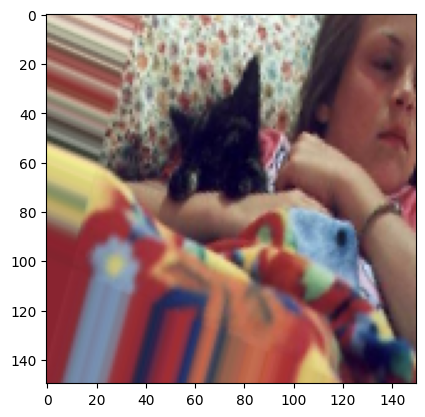

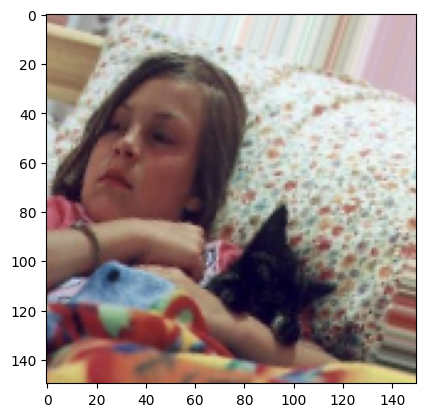

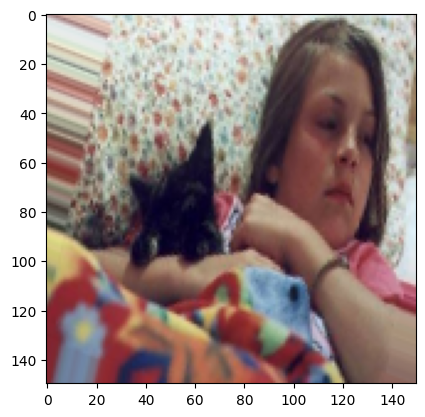

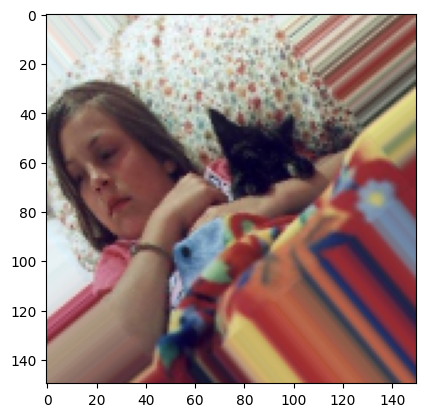

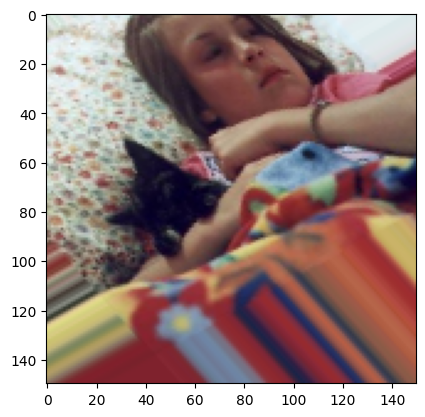

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))  # PIL image
x = img_to_array(img)  # Numpy array (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array (1, 150, 150, 3)

# El comando .flow() genera batches de imágenes transformadas aleatoriamente
# Entra en un bucle infinito, por tanto, tenemos que pararlo en algún momento (break)
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

## Incluir Data Augmentation a nuestro prepocesado

Ahora vamos a añadir nuestras transformaciones de data augmentation a nuestro preprocesado:

In [6]:
# Estas son las transformaciones que vamos a realizar: 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# IMPORTANTE! No tenemos que augmentar los datos de validación!
val_datagen = ImageDataGenerator(rescale=1./255)

# Producimos imágenes en batches de 20 usando el generador train_datagen
train_generator = train_datagen.flow_from_directory(
        train_dir,  # directorio fuente
        target_size=(150, 150),  # Las imágenes se van a reescalar a tamaño 150x150
        batch_size=20,
        # Como utilizamos la función de coste binary_crossentropy loss, necesitamos etiquetas binarias
        class_mode='binary')

# Por último, preparamos los datos de validación
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Si entrenamos una nueva red con esta configuración nunca verá la misma imagen dos veces. Sin embargo las entradas estarán fuertemente correladas, por tanto, puede que esto no sea suficiente para paliar nuestro problema de overfitting.

## Dropout

Estamos ante la técnica más sencilla y a la vez la más popular y efectiva en el mundo del Deep Learning para evitar el sobreentrenamiento!

Vamos a conocer a nuestro amigo: **dropout**

Como decía, es una técnica sencilla pero muy efectiva, pero esta vez os toca a vosotros, emplead unos minutitos en investigar qué es esto del dropout y para qué sirve. Os dejo debajo una fuente de calidad pero sería incluso mejor que busquéis por vuestros propios medios una fuente donde os quede claro (el concepto es sencillo y es difícil que vayais a encontrar una fuente donde os confundan).

Ver [Training Neural Networks](https://developers.google.com/machine-learning/crash-course/training-neural-networks/video-lecture), parte de [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/).

Ahora vamos a reconfigurar nuestra CNN para utilizar dropou justo antes de la capa final de clasificación:

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# Nuestro feature map de entrada es de 150x150x3, con 150x150 píxels y 3 canales (RGB)
img_input = layers.Input(shape=(150, 150, 3))

# La primera convolución extrae 16 filtros de 3x3, relu va diréctamente embebido en esta capa
# La convolución va seguida, en este caso, de una capa de max-pooling con ventanas de 2x2
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# La segunda convolución extrae 32 filtros de 3x3
# La convolución va seguida de una capa de max-pooling con ventanas de 2x2
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# La segunda convolución extrae 64 filtros de 3x3
# La convolución va seguida de una capa de max-pooling con ventanas de 2x2
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Vectorizamos el feature-map de salida mediante la capa flatten
x = layers.Flatten()(x)

# Creamos una capa fully-connected con función de activación ReLU y 512 neuronas
x = layers.Dense(512, activation='relu')(x)

# TODO 2. Añadir una capa de dropout con ratio de drop del 0.5}
x = layers.Dropout(0.5)(x)

# Creamos la capa de salida con un sólo nodo y función de activación sigmoide
output = layers.Dense(1, activation='sigmoid')(x)

# Configuramos y compilamos el modelo
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

## Reentrenando el modelo:

Una vez hemos configurado data augmentation y dropout, tenemos que reentrenar nuestra convnet. Esta vez, vamos a entrenar en las 2000 imágenes disponibles durante 30 épocas y vamos a validar en nuestras 1000 imágenes de validación. 

Adelante!!

In [9]:
# Pon el código en esta celda.

history = model.fit(
    train_generator,
    steps_per_epoch=100,  # 2000 imágenes / batch_size=20 = 100 pasos por época
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,  # 1000 imágenes / batch_size=20 = 50 pasos por época
    verbose=1
)

Epoch 1/30


/opt/anaconda3/envs/yolo/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - acc: 0.5267 - loss: 0.8991 - val_acc: 0.5630 - val_loss: 0.6808
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - acc: 0.5788 - loss: 0.6876 - val_acc: 0.6650 - val_loss: 0.6220
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - acc: 0.6197 - loss: 0.6604 - val_acc: 0.6920 - val_loss: 0.5793
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - acc: 0.6346 - loss: 0.6269 - val_acc: 0.6870 - val_loss: 0.5795
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - acc: 0.6478 - loss: 0.6258 - val_acc: 0.7120 - val_loss: 0.5560
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - acc: 0.6668 - loss: 0.6036 - val_acc: 0.6850 - val_loss: 0.5679
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - acc: 0.6554 - loss: 0.6144 - val_acc: 0.7020 - val_loss: 0.5941
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - acc: 0.6744 - loss: 0.6230 - val_acc: 0.7010 - val_loss: 0.5647
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - acc:

Nótese que una vez tenemos data augmentation, las 2000 imágenes de entrenamiento son transformadas cada vez que corremos una nueva época, por tanto, el modelo no verá la misma imágen dos veces evitando que pueda memorizarla y añadiendo algo de variabilidad a nuestro entrenamiento.

## Evaluando los resultados

Vamos a evaluar los resultados de nuestro modelo ahora que hemos añadido estas técnicas:

Text(0.5, 1.0, 'Training and validation loss')

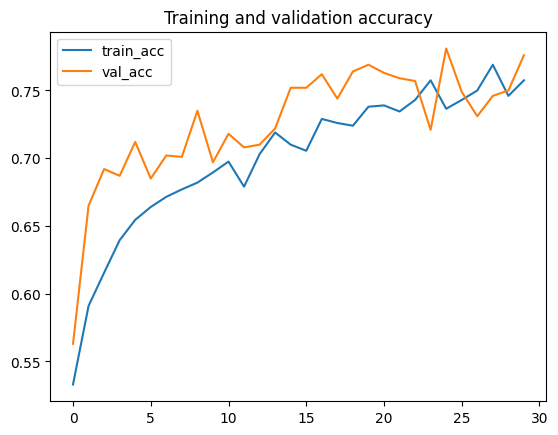

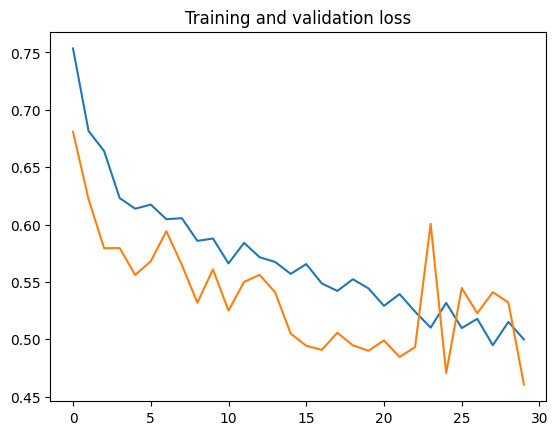

In [10]:
# Podemos extraer los valores de accuracy y loss del histórico que se ha guardado al entrenar la red
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Extraemos el número de épocas
epochs = range(len(acc))

# Representamos con plot nuestro accuracy por epoch
plt.plot(epochs, acc, label = 'train_acc')
plt.plot(epochs, val_acc, label = 'val_acc')
plt.title('Training and validation accuracy')

plt.legend()
plt.figure()

# Representamos con plot nuestro loss por epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Mucho mejor! Ya no estamos sobreentrenando y hemos ganado ~3 puntos porcentuales en nuestro accuracy de validación (ver línea verde en la gráfica superior). De hecho, a juzgar por nuestra curva de entrenamiento, podríamos seguir entrenando nuestro modelo durante más épocas y quizá podríamos llegar cerca del ~80%!


Entrenando modelo con dropout rate = 0.9
Epoch 1/30


/opt/anaconda3/envs/yolo/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - acc: 0.4883 - loss: 0.7057 - val_acc: 0.5000 - val_loss: 0.6931
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - acc: 0.5133 - loss: 0.6933 - val_acc: 0.5030 - val_loss: 0.6923
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - acc: 0.5032 - loss: 0.6944 - val_acc: 0.5700 - val_loss: 0.6774
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - acc: 0.5294 - loss: 0.6920 - val_acc: 0.5200 - val_loss: 0.6733
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - acc: 0.5434 - loss: 0.6874 - val_acc: 0.5560 - val_loss: 0.6782
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - acc: 0.5664 - loss: 0.6836 - val_acc: 0.5570 - val_loss: 0.6508
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - acc: 0.5795 - loss: 0.6606 - val_acc: 0.6620 - val_loss: 0.6248
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - acc: 0.5982 - loss: 0.6818 - val_acc: 0.6710 - val_loss: 0.6398
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s

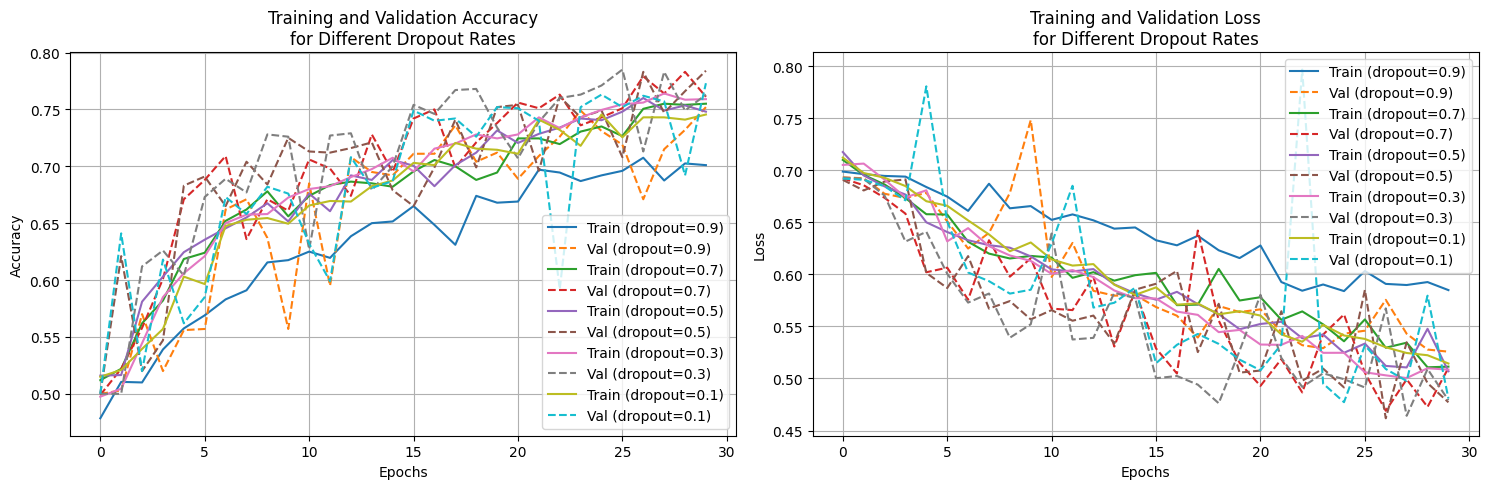


Estadísticas finales para cada valor de dropout:
--------------------------------------------------

Dropout = 0.9:
Train Accuracy: 0.7010
Val Accuracy: 0.7520
Train Loss: 0.5849
Val Loss: 0.5257
Diferencia Train-Val Accuracy: 0.0510

Dropout = 0.7:
Train Accuracy: 0.7550
Val Accuracy: 0.7610
Train Loss: 0.5114
Val Loss: 0.5101
Diferencia Train-Val Accuracy: 0.0060

Dropout = 0.5:
Train Accuracy: 0.7480
Val Accuracy: 0.7840
Train Loss: 0.5069
Val Loss: 0.4771
Diferencia Train-Val Accuracy: 0.0360

Dropout = 0.3:
Train Accuracy: 0.7590
Val Accuracy: 0.7630
Train Loss: 0.5085
Val Loss: 0.4791
Diferencia Train-Val Accuracy: 0.0040

Dropout = 0.1:
Train Accuracy: 0.7455
Val Accuracy: 0.7730
Train Loss: 0.5144
Val Loss: 0.4807
Diferencia Train-Val Accuracy: 0.0275


In [14]:
# Importar las librerías necesarias
from tensorflow.keras import models, layers

# Función para entrenar el modelo con diferentes dropouts
def train_model_with_dropout(dropout_rate):
    # Crear el modelo
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),  # Aplicamos el dropout con la tasa especificada
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Compilar el modelo
    model.compile(loss='binary_crossentropy',
                 optimizer=RMSprop(learning_rate=0.001),
                 metrics=['acc'])
    
    # Entrenar el modelo
    history = model.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=50,
        verbose=1
    )
    
    return history

# Función para graficar los resultados
def plot_dropout_comparison(histories):
    plt.figure(figsize=(15, 5))
    
    # Subplot para accuracy
    plt.subplot(1, 2, 1)
    for rate, history in histories.items():
        plt.plot(history.history['acc'], label=f'Train (dropout={rate})')
        plt.plot(history.history['val_acc'], '--', label=f'Val (dropout={rate})')
    plt.title('Training and Validation Accuracy\nfor Different Dropout Rates')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Subplot para loss
    plt.subplot(1, 2, 2)
    for rate, history in histories.items():
        plt.plot(history.history['loss'], label=f'Train (dropout={rate})')
        plt.plot(history.history['val_loss'], '--', label=f'Val (dropout={rate})')
    plt.title('Training and Validation Loss\nfor Different Dropout Rates')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Función para mostrar estadísticas
def print_dropout_statistics(histories):
    print("\nEstadísticas finales para cada valor de dropout:")
    print("-" * 50)
    for rate, history in histories.items():
        final_train_acc = history.history['acc'][-1]
        final_val_acc = history.history['val_acc'][-1]
        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]
        
        print(f"\nDropout = {rate}:")
        print(f"Train Accuracy: {final_train_acc:.4f}")
        print(f"Val Accuracy: {final_val_acc:.4f}")
        print(f"Train Loss: {final_train_loss:.4f}")
        print(f"Val Loss: {final_val_loss:.4f}")
        print(f"Diferencia Train-Val Accuracy: {abs(final_train_acc - final_val_acc):.4f}")

# Ejecutar el entrenamiento con diferentes dropouts
dropout_rates = [0.9, 0.7, 0.5, 0.3, 0.1]
histories = {}

for rate in dropout_rates:
    print(f"\nEntrenando modelo con dropout rate = {rate}")
    histories[rate] = train_model_with_dropout(rate)

# Visualizar resultados
plot_dropout_comparison(histories)
print_dropout_statistics(histories)

## Clean Up

Antes de correr el siguiente ejercicio, corre la sigueinte celda para finalizar el kernel y liberar la memoria.

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

: 